In [5]:
!pip install -Uqq fastai duckduckgo_search fastdownload


In [4]:
!pip install -Uqq ddgs


In [6]:
#inorder to search and download images from the internet.
from ddgs import DDGS
#for better data handling along with Fastai.
from fastcore.all import *

def search_img(keywords,max_images = 250):
    return L(DDGS().images(keywords,max_results = max_images)).itemgot('image')


#what happens above is - it search on DuckDuckGO with the keywords and gets the image URL's and the L.itemgot() will extract only the image

import time,json


In [7]:
urls = search_img('bird photos',max_images = 1)
urls[0]

'https://images.pexels.com/photos/97533/pexels-photo-97533.jpeg?cs=srgb&dl=animal-avian-bird-97533.jpg&fm=jpg'

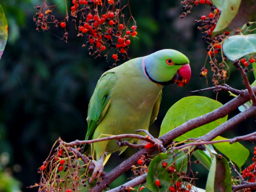

In [8]:
#downloading the above single image.

from fastdownload import download_url
destination = 'bird.jpg'
download_url(urls[0],destination,show_progress=True)

#using pillow from fastai to display the image.

from fastai.vision.all import *
ima = Image.open(destination)
ima.to_thumb(256,256)

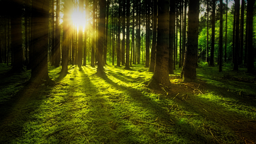

In [9]:
#Same procedure for forest.
urls = search_img('forest photos',max_images = 1)

dest = 'forest.jpg'
download_url(urls[0],dest,show_progress = True)

im = Image.open(dest)
im.to_thumb(256,256)

In [10]:
#Having more set of photos of both.

searches = 'forest','bird'
path = Path('bird_or_not')

for k in searches : #making two folders seperate for forest and bird under bird_or_not folder.
    dest = (path/k)
    dest.mkdir(exist_ok = True,parents = True)
    download_images(dest,urls=search_img(f'{k} photo'))
    time.sleep(5) #to avoid rate limit of search
    resize_images(path/k,max_size = 400,dest = path/k)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


In [11]:
#Removing failed downloads.
failed_imgs = verify_images(get_image_files(path))
failed_imgs.map(Path.unlink)
len(failed_imgs)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)


16

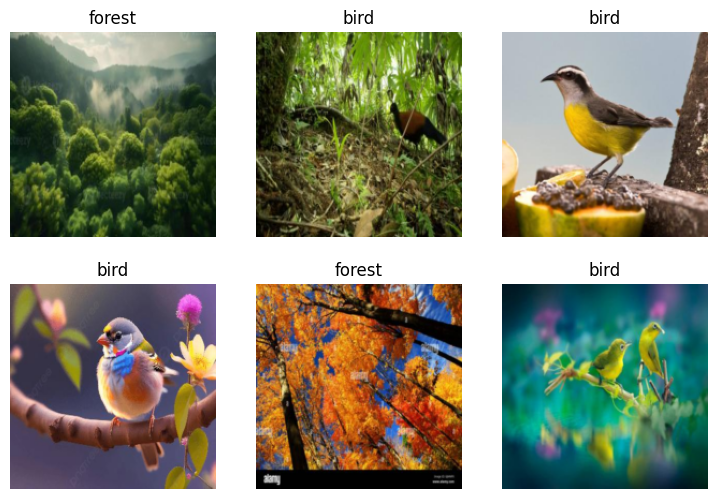

In [12]:
#Setting up the DataLoaders for training and validatioin set

dls = DataBlock(
    #input the images and output with categories/labels.
    blocks = (ImageBlock,CategoryBlock),
    get_items = get_image_files,
    splitter = RandomSplitter(valid_pct= 0.2,seed = 42),
    get_y = parent_label, #get label from the parent folder name
    item_tfms = [Resize(192,method='squish')] #by squishing method - resizes all images.

).dataloaders(path,bs=32) #create dataloaders with batch size = 32
dls.show_batch(max_n=6)

In [13]:
#Using fastest computer vision model resnet18

learn = vision_learner(dls,resnet18,metrics = error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 190MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,1.095466,0.941152,0.371429,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.404243,0.101819,0.057143,00:00
1,0.345788,0.034356,0.000000,00:00
2,0.240406,0.035470,0.028571,00:00


So the above code , will creates a convolutional neural network(CNN) using FastAi's vision_learner

This model comes with pretrained weight,that it trained on a large dataset called ImageNet ,so we only need to fine tune it according to our needs.


In [18]:
#Prediction using the training.
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg')) #converting the first image so fastAi can process it.
print(f"This is a: {is_bird}.")
print(f"It's  class index : {_}")
print(f"Probability it's a bird: {probs[0]:.4f}")


This is a: bird.
It's  class index : 0
Probability it's a bird: 0.9994


In [17]:
out,ind,prob = learn.predict(PILImage.create('forest.jpg'))
print(f"This is a : {out}")
print(f"It's class index : {ind}")
print(f"Probability it's a forest:{prob[1]:.4f}")

This is a : forest
It's class index : 1
Probability it's a forest:1.0000
